# **Employee Attrition Prediction (HR) - Salifort Motors**

## Model Building and Evaluation

This notebook focuses on **building and evaluating a machine learning model (Logistic Regression)** to predict employee attrition. <br>
We will preprocess the data, train various classification algorithms, and assess their performance using appropriate evaluation metrics. The goal is to identify the most effective model for predicting whether an employee is likely to leave the company.

## Type of models

Since the variable we want to predict (whether an employee leaves the company) is categorical, we could either build a **Logistic Regression model**, or a **Tree-based Machine Learning model**.

In this Notebook we will focus on the **Logistic Regression model**.

## Logistic Regression

This section focuses on building and evaluating a **Logistic Regression model** to predict employee attrition. Before applying the model, it's essential to consider the underlying **assumptions of Logistic Regression**, which must be reasonably met to ensure reliable results:

- The **outcome variable is categorical**, representing whether an employee left the company or not.

- **Observations are independent**, meaning the behavior of one employee does not influence another.

- There is no **severe multicollinearity** among the independent variables.

- The dataset does not contain **extreme outliers** that could distort the model.

- There is a **linear relationship** between each independent variable and the logit of the outcome.

- The dataset has a **sufficient sample size** to ensure model stability.

In the following steps, we will validate these assumptions and proceed with model training, evaluation, and interpretation.

### Library Imports

In [4]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data modeling and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

### Data Loading

In [5]:
# Load dataset
df = pd.read_csv('Salifort_Motors_HR_dataset_cleaned.csv')

In [6]:
# Information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_monthly_hours  11991 non-null  int64  
 4   tenure                 11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 936.9+ KB


### Encoding

Before splitting the data, we have to **encode the non-numeric variables**. There are two: 'department' and 'salary'.

**'department'** is a categorical variable, which means we can dummy it for modeling.

**'salary'** is categorical too, but it is **ordinal**. There is a hierarchy to the categories, so it is better not to dummy this columnm. We rather convert the levels to numbers from 0-2.

In [7]:
# Copy of the dataframe
df_enc = df.copy()

# Encode 'salary' column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary']
    .astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
    )

# Dummy encode the 'department' column
df_enc = pd.get_dummies(df_enc, drop_first = False)

# Display new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [8]:
# Save encoded dataset
df_enc.to_csv('Salifort_Motors_HR_dataset_encoded.csv', index=False)

### Feature Correlation

In the last Notebook we confirmed that the **number of projects, monthly hours, and evaluation scores** all have some positive correlation with each other, and whether an employee leaves is negatively correlated with their **satisfaction level**.

We create a **heatmap** to visualize how correlated these variables are.

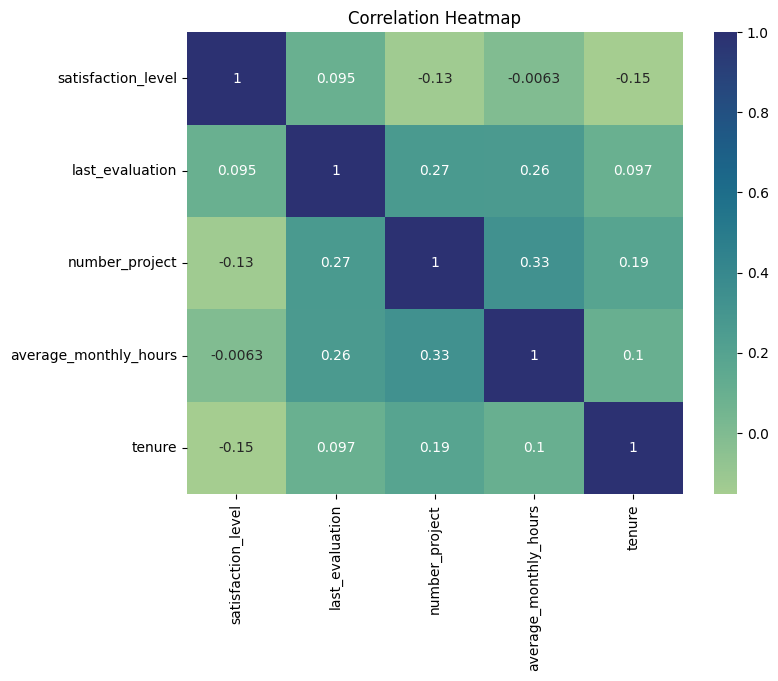

In [9]:
# Correlation Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap='crest')
plt.title('Correlation Heatmap')
plt.show()

### Outliers

Since Logistic Regression is quite sensitive to outliers, we remove the  outliers in the 'tenure' column.

To achieve this, we use Interquartile Range (IQR) method to calculate the upper and lower bounds and filter out any values outside of this range.



In [10]:
# Define IQR, Upper and Lower Bounds
Q1 = df['tenure'].quantile(0.25)
Q3 = df['tenure'].quantile(0.75)

IQR = Q3 - Q1

LowBound = Q1 - 1.5 * IQR
UppBound = Q3 + 1.5 * IQR

In [11]:
# Filter outliers in 'tenure' and save resulting dataframe
df_logreg = df_enc[(df_enc['tenure'] >= LowBound) & (df_enc['tenure'] <= UppBound)]

# Display the results
df_logreg.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary
count,11167.000000,11167.000000,11167.000000,11167.000000,11167.000000,11167.000000,11167.000000,11167.000000,11167.000000
mean,0.631944,0.715901,3.786066,200.144533,3.109161,0.152413,0.168532,0.014417,0.592997
std,0.239064,0.167595,1.164198,48.563047,0.899277,0.359437,0.374355,0.119209,0.632227
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,0.490000,0.570000,3.000000,157.000000,2.000000,0.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,199.000000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,7.000000,310.000000,5.000000,1.000000,1.000000,1.000000,2.000000


### Outcome Variable and Features

Next, we **isolate the outcome variable 'left'** in order to separate the target from the features. <br>
This is a crucial step in supervised learning, as the model needs to learn patterns in the input features that are associated with the target outcome.

In [12]:
# Isolate the outcome variable
y = df_logreg['left']

# Select the features we want to use in your model
X = df_logreg.drop('left', axis=1)

### Model building

In [13]:
# Split data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [14]:
# Construct a logistic regression model and fit training set
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [15]:
# Use model to get predictions on the test set
y_pred = log_clf.predict(X_test)

### Confusion Matrix

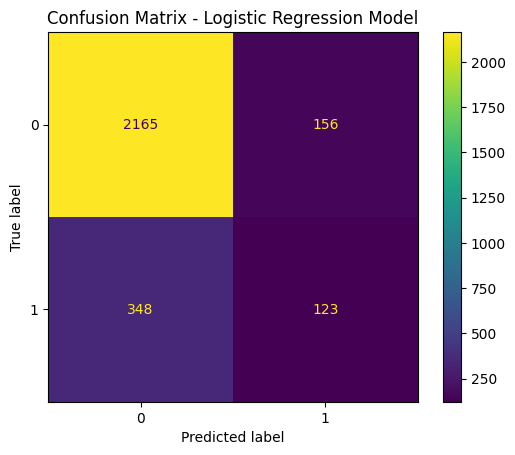

In [19]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display for cm
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                                  display_labels=log_clf.classes_)

# Plot cm
log_disp.plot(values_format='')

# Display plot
plt.title('Confusion Matrix - Logistic Regression Model')
plt.show()

The **upper-left quadrant** displays the number of **true negatives**. <br>
The **upper-right quadrant** displays the number of **false positives**. <br>
The **bottom-left quadrant** displays the number of **false negatives**. <br>
The **bottom-right quadrant** displays the number of **true positives**.

- **True negatives**: The number of people who did not leave that the model accurately predicted did not leave.

- **False positives**: The number of people who did not leave the model inaccurately predicted as leaving.

- **False negatives**: The number of people who left that the model inaccurately predicted did not leave

- **True positives**: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

### Classification Report

In [17]:
targetnames = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names = targetnames))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



## Results and Evaluation

The Logistic Regression model was evaluated on the test set and achieved the following weighted average performance metrics:

**Precision: 79%** <br>
This indicates that, out of all the positive predictions made by the model, 79% were true positives. In other words, the model performed reasonably well in avoiding false positives.

**Recall: 82%** <br>
The recall metric shows that 82% of all actual positive instances were correctly identified by the model. This means the model did a good job of capturing most of the positive cases, but there is still room for improvement in minimizing false negatives.

**F1-Score: 80%** <br>
The F1-Score is the harmonic mean of precision and recall, balancing the trade-off between them. An F1-Score of 80% shows a solid overall performance, where the model's ability to correctly classify positive cases is balanced with its ability to minimize false positives and negatives.

**Accuracy: 82%** <br>
Accuracy, which is the proportion of correct predictions (both positive and negative) out of all predictions made, stands at 82%. This suggests that the model overall performs quite well across all classes, though accuracy alone can sometimes be misleading, especially with imbalanced classes.



## Conclusion


The Logistic Regression model performed well with a good balance between precision and recall. The F1-score reinforces the model's effectiveness, and the relatively high accuracy indicates it is a reliable model for this task.